In [1]:
import librosa
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import cv2
import dlib
import pygame
import soundfile as sf
from collections import deque
from scipy.special import softmax
# Initialize pygame mixer
pygame.mixer.init()


import soundfile as sf
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from IPython.display import Audio
def show_audio(y, sr, normalise=True):
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.show()
    
    # Return the audio player
    return Audio(y, rate=sr, normalize=normalise, autoplay=True)


pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:

# Load pre-trained models
rf_model = joblib.load('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/random_forest_model.pkl')
scaler = joblib.load('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/scaler.pkl')
cnn_model = load_model('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/model.h5', custom_objects={'swish': tf.nn.swish})

# Compile the CNN model (not necessary for prediction, but useful for debugging)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/haar/haarcascade_frontalface_alt2.xml')
if face_cascade.empty():
    raise IOError("Failed to load Haar Cascade file. Please check the file path.")

# Load Dlib's shape predictor for facial landmarks
shape_predictor = dlib.shape_predictor('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/shape_predictor_68_face_landmarks.dat')

# Define emotions map
emotion_map = {'angry-face': 'angry', 'happy-face': 'happy', 'sad-face': 'sad', 'neutral-face': 'neutral'}

# Emotion buffer for smoothing predictions
emotion_buffer = deque(maxlen=20)  # Keep last 10 frames

# Path to neutral song
neutral_song_path = 'Music/happy/arpa_bugday_daneler_muazzez_ersoy.mp3'

# Load and play the initial song
pygame.mixer.music.load(neutral_song_path)
pygame.mixer.music.play()

# Function to manipulate audio based on emotion
def manipulate_audio(file_path, emotion):
    y, sr = librosa.load(file_path)
    
    # Adjust tempo based on the emotional states
    if emotion == 'happy':
        y_fast = librosa.effects.time_stretch(y, rate=1.9)
    elif emotion == 'sad':
        y_fast = librosa.effects.time_stretch(y, rate=0.9)
    elif emotion == 'angry':
        y_fast = librosa.effects.time_stretch(y, rate=1.5)
    else:  # Neutral
        y_fast = librosa.effects.time_stretch(y, rate=1.0)

    # Adjust pitch and apply additional effects for "angry"
    if emotion == 'angry':
        y_shifted = librosa.effects.pitch_shift(y_fast, sr=sr, n_steps=5)
        y_shifted = np.tanh(y_shifted * 15)
        y_shifted = librosa.effects.preemphasis(y_shifted, coef=1)
    elif emotion == 'sad':
        y_shifted = librosa.effects.pitch_shift(y_fast, sr=sr, n_steps=-4)
    else:
        y_shifted = y_fast

    return y_shifted, sr

# Initialize video capture
cap = cv2.VideoCapture(0) 

if not cap.isOpened():
    print("Error: Could not open video capture.")
    exit()

current_emotion = 'neutral'

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw bounding box around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (36, 255, 12), 2)

        # Get the landmarks
        dlib_rect = dlib.rectangle(x, y, x + w, y + h)
        landmarks = shape_predictor(gray, dlib_rect)

        # Extract facial features for Random Forest
        left_eye = np.array([landmarks.part(36).x, landmarks.part(36).y])
        right_eye = np.array([landmarks.part(45).x, landmarks.part(45).y])
        nose_tip = np.array([landmarks.part(30).x, landmarks.part(30).y])
        mouth_left = np.array([landmarks.part(48).x, landmarks.part(48).y])
        mouth_right = np.array([landmarks.part(54).x, landmarks.part(54).y])
        chin = np.array([landmarks.part(8).x, landmarks.part(8).y])
        left_eyebrow = np.array([landmarks.part(21).x, landmarks.part(21).y])
        right_eyebrow = np.array([landmarks.part(22).x, landmarks.part(22).y])
        
        # Calculate distances and angles (features used during training)
        total_face_area = w * h
        left_eyebrow_angle = np.arctan2(left_eyebrow[1] - left_eye[1], left_eyebrow[0] - left_eye[0])
        right_eyebrow_angle = np.arctan2(right_eyebrow[1] - right_eye[1], right_eyebrow[0] - right_eye[0])
        eyebrow_distance = np.linalg.norm(left_eyebrow - right_eyebrow)
        eyes_dist = np.linalg.norm(left_eye - right_eye)
        eyes_to_nose_dist = np.linalg.norm((left_eye + right_eye) / 2 - nose_tip)
        nose_to_mouth_dist = np.linalg.norm(nose_tip - (mouth_left + mouth_right) / 2)
        mouth_angle = np.arctan2(mouth_right[1] - mouth_left[1], mouth_right[0] - mouth_left[0])
        nose_angle = np.arctan2(nose_tip[1] - chin[1], nose_tip[0] - chin[0])

        # Prepare the feature vector for Random Forest
        features = np.array([[total_face_area, left_eyebrow_angle, right_eyebrow_angle, eyebrow_distance, 
                              eyes_dist, eyes_to_nose_dist, nose_to_mouth_dist, mouth_angle, nose_angle]])

        # Use the original feature names used during fitting
        original_feature_names = ['TotalFaceArea', 'LeftEyebrowAngle', 'RightEyebrowAngle', 'EyebrowDistance', 
                                  'EyesDist', 'EyesToNoseDist', 'NoseToMouthDist', 'MouthAngle', 'NoseAngle']
        features_df = pd.DataFrame(features, columns=original_feature_names)

        # Scale the features
        features_scaled = scaler.transform(features_df)

        # Predict the emotion with Random Forest
        rf_emotion_label = rf_model.predict(features_scaled)[0]
        print("RF Emotion Label:", rf_emotion_label)  # Debugging: Print RF label
        rf_emotion_text = emotion_map.get(rf_emotion_label, "Unknown")

        # Prepare the image for CNN (150x150 as per your earlier configuration)
        face_img = cv2.resize(frame[y:y+h, x:x+w], (150, 150))
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        face_img = face_img / 255.0  # Normalize to [0, 1]
        face_img = np.expand_dims(face_img, axis=-1)  # Add channel dimension for grayscale
        face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension

        # Predict the emotion with CNN
        cnn_predictions = cnn_model.predict(face_img)
        print("CNN Predictions:", cnn_predictions)  # Debugging: Print raw predictions
        cnn_probabilities = softmax(cnn_predictions, axis=1)  # Apply softmax to get probabilities
        print("CNN Probabilities:", cnn_probabilities)  # Debugging: Print probabilities
        cnn_emotion_label = int(np.argmax(cnn_probabilities, axis=1)[0])
        cnn_emotion_text = emotion_map.get(cnn_emotion_label, "Unknown")

        # Combine the predictions using weighted voting
        if rf_emotion_text == cnn_emotion_text:
            final_emotion_text = rf_emotion_text
        else:
            # Use softmax probabilities to weigh the decision
            rf_weight = 0.5  # Example weight for Random Forest
            cnn_weight = cnn_probabilities[0][cnn_emotion_label]  # Use the probability of the predicted class
            if cnn_weight > rf_weight:
                final_emotion_text = cnn_emotion_text
            else:
                final_emotion_text = rf_emotion_text

        # Debugging: Print final emotion decision
        print("Final Emotion Text:", final_emotion_text)

        # Display the emotion on the frame
        cv2.putText(frame, final_emotion_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

        # Add the predicted emotion to the buffer
        emotion_buffer.append(final_emotion_text)

        # Get the most common emotion in the buffer
        common_emotion = max(set(emotion_buffer), key=emotion_buffer.count)

        # Change the music only if the emotion has stabilized
        if common_emotion != current_emotion and emotion_buffer.count(common_emotion) > 15:
            current_emotion = common_emotion
            y_shifted, sr = manipulate_audio(neutral_song_path, current_emotion)
            sf.write('modified_song.wav', y_shifted, sr)
            pygame.mixer.music.fadeout(1000)  # Fade out current music
            pygame.mixer.music.load('modified_song.wav')  # Load new song
            pygame.mixer.music.play()

    # Display the frame with face and emotion overlay
    cv2.imshow('Emotion Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()
pygame.mixer.quit()

RF Emotion Label: happy-face
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
CNN Predictions: [[0.0170868  0.00230482 0.0342394  0.946369  ]]
CNN Probabilities: [[0.1806581  0.17800726 0.18378359 0.4575511 ]]
Final Emotion Text: happy
RF Emotion Label: angry-face
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
CNN Predictions: [[0.04203844 0.01711059 0.49108145 0.44976956]]
CNN Probabilities: [[0.19819267 0.19331321 0.31053066 0.2979634 ]]
Final Emotion Text: angry
RF Emotion Label: angry-face
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
CNN Predictions: [[0.02627192 0.01733203 0.70826375 0.24813229]]
CNN Probabilities: [[0.19166966 0.18996377 0.37908676 0.23927982]]
Final Emotion Text: angry
RF Emotion Label: angry-face
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
CNN Predictions: [[0.01806362 0.02298202 0.7943027  0.16465159]]
CNN Probabilities: [[0.18740313 0.18832712 0.4072801  0.21698974]]
Final Emotion Text: angry
RF Emotion Label: angry-face
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
CNN Predictions: [[0.01349475 0.

: 

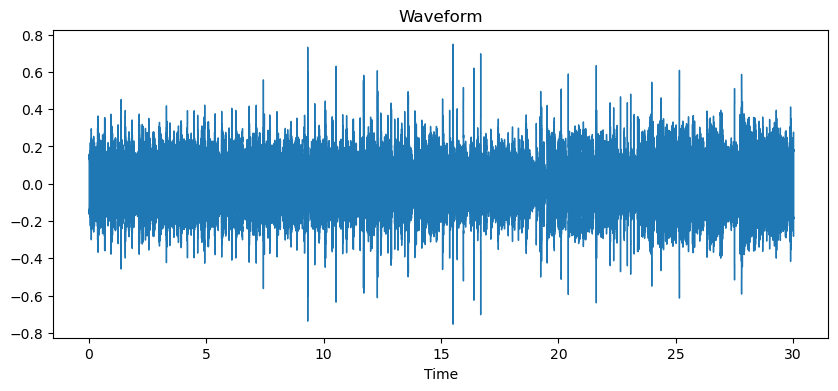

In [9]:
# play origional song
y, sr = librosa.load('Music/happy/arpa_bugday_daneler_muazzez_ersoy.wav')#'/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/modified_song_angry.wav'
show_audio(y, sr)